<a href="https://colab.research.google.com/github/celsoneto2002/TrabalhoBigData/blob/main/CodigoBIGDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd

# Fazer upload dos arquivos CSV (2023, 2024, 2025)
enviados = files.upload()
list(enviados.keys())


Saving sinannet_cnv_denguebbr180802170_254_202_121.csv to sinannet_cnv_denguebbr180802170_254_202_121.csv
Saving sinannet_cnv_denguebbr180827170_254_202_121.csv to sinannet_cnv_denguebbr180827170_254_202_121.csv
Saving sinannet_cnv_denguebbr180845170_254_202_121.csv to sinannet_cnv_denguebbr180845170_254_202_121.csv


['sinannet_cnv_denguebbr180802170_254_202_121.csv',
 'sinannet_cnv_denguebbr180827170_254_202_121.csv',
 'sinannet_cnv_denguebbr180845170_254_202_121.csv']

In [2]:
# Lista de meses em ordem
MESES_PT = ["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"]

def encontrar_cabecalho(caminho, encoding="latin-1"):
    """Encontra a linha do cabeçalho no CSV do SINAN"""
    with open(caminho, "r", encoding=encoding) as f:
        for i, linha in enumerate(f):
            if ";" in linha and "Ano" in linha and any(m in linha for m in MESES_PT):
                return i
    raise RuntimeError(f"Não encontrei o cabeçalho no arquivo: {caminho}")

def converter_numeros(coluna: pd.Series) -> pd.Series:
    """Converte valores de string para número inteiro"""
    coluna = coluna.astype(str).str.strip().replace({"-": "0", "": "0"})
    tem_virgula = coluna.str.contains(",", regex=False)
    parte_virgula = coluna[tem_virgula].str.replace(".", "", regex=False).str.replace(",", ".", regex=False)
    parte_sem_virgula = coluna[~tem_virgula]
    coluna_final = pd.concat([parte_virgula, parte_sem_virgula]).sort_index()
    return pd.to_numeric(coluna_final, errors="coerce").fillna(0).round().astype(int)

def carregar_sinan(caminho: str) -> pd.DataFrame:
    """Carrega, limpa e organiza o arquivo CSV"""
    cabecalho = encontrar_cabecalho(caminho)
    df = pd.read_csv(caminho, sep=";", encoding="latin-1", header=cabecalho, quotechar='"')
    df = df.rename(columns={df.columns[0]: "Ano"})
    df = df[df["Ano"].astype(str).str.match(r"^\d{4}$|^Total$", na=False)]
    if "Total" in df.columns:
        df = df.drop(columns=["Total"])
    for col in df.columns[1:]:
        df[col] = converter_numeros(df[col])
    df = df[~df["Ano"].astype(str).str.fullmatch("Total")]
    df["Ano"] = df["Ano"].astype(int)
    colunas = ["Ano"] + [m for m in MESES_PT if m in df.columns]
    df = df[colunas]
    df_longo = df.melt(id_vars=["Ano"], var_name="Mês", value_name="Casos")
    df_longo["Mês"] = pd.Categorical(df_longo["Mês"], categories=MESES_PT, ordered=True)
    return df_longo.sort_values(["Ano","Mês"]).reset_index(drop=True)


In [3]:
dados = []
for nome, conteudo in enviados.items():
    with open(nome, "wb") as f:
        f.write(conteudo)  # grava o arquivo
    dados.append(carregar_sinan(nome))

# Junta todos os dados em um só DataFrame
df = pd.concat(dados, ignore_index=True)
df.head()
dados = []
for nome, conteudo in enviados.items():
    with open(nome, "wb") as f:
        f.write(conteudo)  # grava o arquivo
    dados.append(carregar_sinan(nome))

# Junta todos os dados em um só DataFrame
df = pd.concat(dados, ignore_index=True)
df.head()


,Ano,Mês,Casos
0,2023,Jan,67621
1,2023,Fev,133460
2,2023,Mar,312726
3,2023,Abr,399750
4,2023,Mai,277199


,Ano,Casos,Frequência (%)
0,2023,1508653,15.96
1,2024,6421942,67.92
2,2025,1524230,16.12


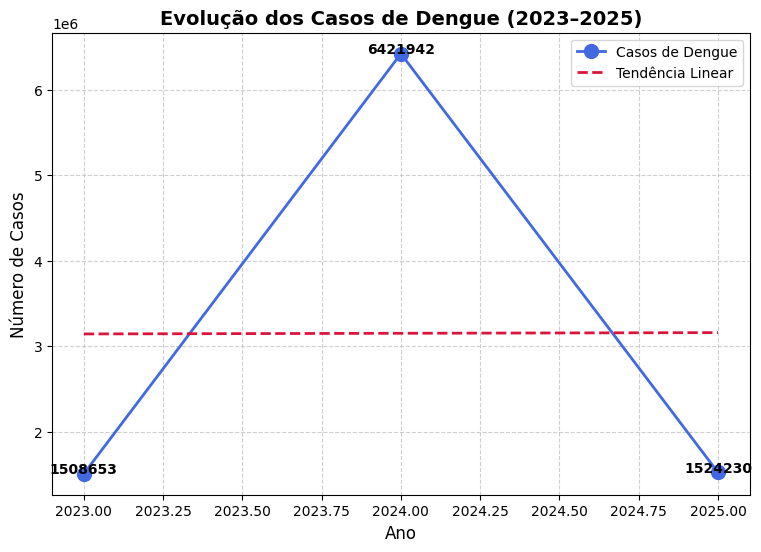

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Casos anuais
df_anual = df.groupby("Ano", as_index=False)["Casos"].sum()
df_anual["Frequência (%)"] = (df_anual["Casos"] / df_anual["Casos"].sum() * 100).round(2)
display(df_anual)

# Regressão linear
x = df_anual["Ano"].values.astype(float)
y = df_anual["Casos"].values.astype(float)
m, b = np.polyfit(x, y, 1)
y_pred = m*x + b

# Gráfico melhorado
plt.figure(figsize=(9,6))
plt.plot(df_anual["Ano"], df_anual["Casos"],
         marker="o", markersize=10, linewidth=2, color="royalblue", label="Casos de Dengue")
plt.plot(df_anual["Ano"], y_pred,
         linestyle="--", linewidth=2, color="crimson", label="Tendência Linear")

# Adiciona valores nos pontos
for i, v in enumerate(df_anual["Casos"]):
    plt.text(df_anual["Ano"].iloc[i], v+2000, str(v),
             ha="center", fontsize=10, color="black", fontweight="bold")

plt.title("Evolução dos Casos de Dengue (2023–2025)", fontsize=14, fontweight="bold")
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Número de Casos", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


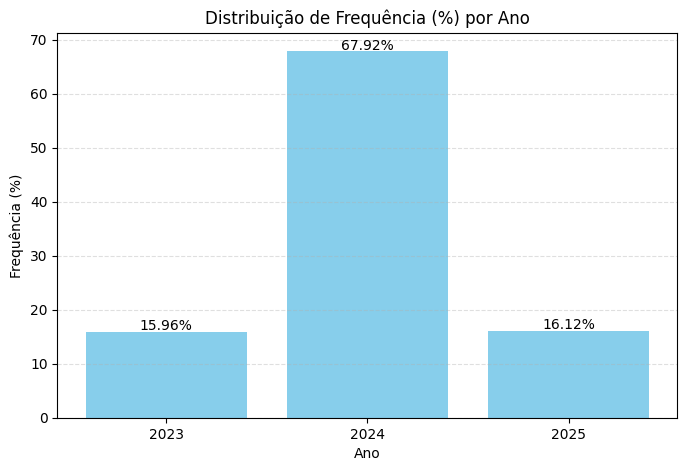

In [5]:
plt.figure(figsize=(8,5))
plt.bar(df_anual["Ano"].astype(str), df_anual["Frequência (%)"], color="skyblue")
for i, v in enumerate(df_anual["Frequência (%)"]):
    plt.text(i, v+0.3, f"{v}%", ha="center")
plt.title("Distribuição de Frequência (%) por Ano")
plt.xlabel("Ano")
plt.ylabel("Frequência (%)")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()


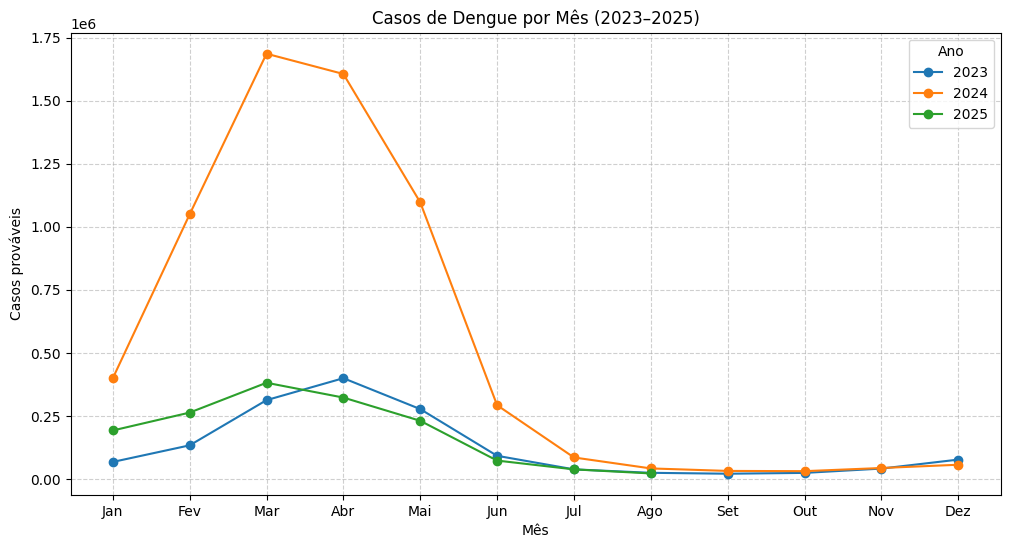

In [6]:
plt.figure(figsize=(12,6))
for ano in sorted(df["Ano"].unique()):
    dados_ano = df[df["Ano"] == ano]
    plt.plot(dados_ano["Mês"].astype(str), dados_ano["Casos"], marker="o", label=str(ano))

plt.title("Casos de Dengue por Mês (2023–2025)")
plt.xlabel("Mês")
plt.ylabel("Casos prováveis")
plt.legend(title="Ano")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


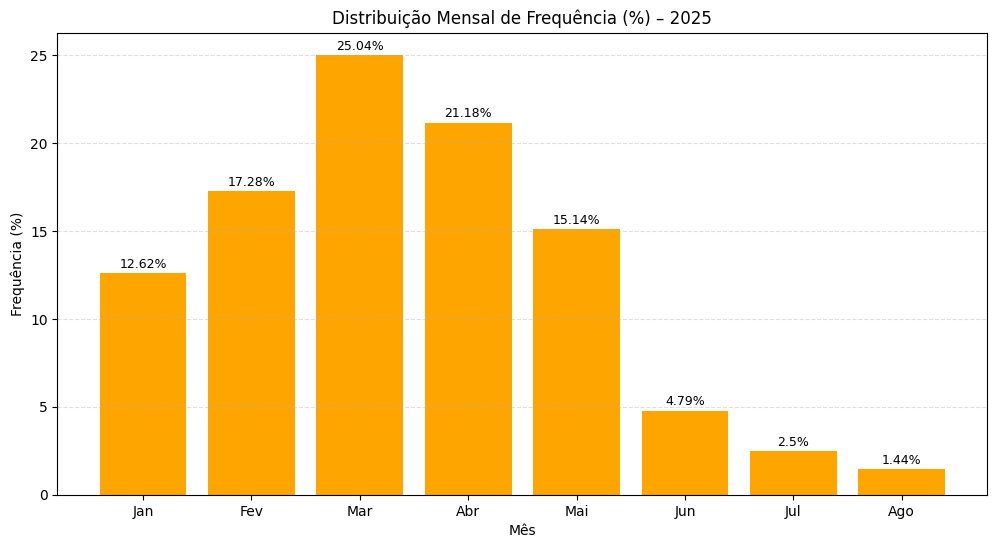

In [7]:
ano_escolhido = 2025  # você pode trocar para 2023, 2024 ou 2025

df_focus = df[df["Ano"] == ano_escolhido].copy()
total_focus = df_focus["Casos"].sum()
df_focus["Frequência (%)"] = (df_focus["Casos"] / total_focus * 100).round(2)

plt.figure(figsize=(12,6))
plt.bar(df_focus["Mês"].astype(str), df_focus["Frequência (%)"], color="orange")
for i, v in enumerate(df_focus["Frequência (%)"]):
    plt.text(i, v+0.3, f"{v}%", ha="center", fontsize=9)

plt.title(f"Distribuição Mensal de Frequência (%) – {ano_escolhido}")
plt.xlabel("Mês")
plt.ylabel("Frequência (%)")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()
